In [2]:
import torch
import torch.nn as nn
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

In [3]:
class FunctionEstimator:
    """
    Base class for all function estimators.
    """
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def fit(self, x, y):
        raise NotImplementedError("fit method must be implemented in subclasses.")

    def predict(self, x):
        raise NotImplementedError("predict method must be implemented in subclasses.")

In [4]:
class LinearEstimator(FunctionEstimator):
    """
    Linear Estimator: Approximates f(x) using a linear model y = Wx + b.
    """
    def __init__(self, input_dim):
        super().__init__(input_dim)
        self.model = nn.Linear(input_dim, 1, bias=True)

    def fit(self, x, y, epochs=500, lr=0.01):
        """
        Train the linear model using mean squared error loss.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for _ in range(epochs):
            optimizer.zero_grad()
            y_pred = self.model(x).squeeze()
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

    def predict(self, x):
        """
        Predict values for new inputs using the trained linear model.
        """
        with torch.no_grad():
            return self.model(x).squeeze()

In [5]:
class NNEstimator(FunctionEstimator):
    """
    Neural Network Estimator: Approximates f(x) using a feed-forward neural network.
    """
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__(input_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def fit(self, x, y, epochs=500, lr=0.01):
        """
        Train the neural network using mean squared error loss.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for _ in range(epochs):
            optimizer.zero_grad()
            y_pred = self.model(x).squeeze()
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

    def predict(self, x):
        """
        Predict values for new inputs using the trained neural network.
        """
        with torch.no_grad():
            return self.model(x).squeeze()

In [6]:
class GaussianKernelEstimator(FunctionEstimator):
    """
    Gaussian Kernel Estimator: Approximates f(x) using a Gaussian kernel.
    """
    def __init__(self, input_dim, bandwidth):
        super().__init__(input_dim)
        self.bandwidth = bandwidth

    def fit(self, x, y):
        """
        Store training data and target values for kernel-based estimation.
        """
        self.x_train = x
        self.y_train = y

    def predict(self, x):
        """
        Predict values using Gaussian kernel-based weighted averaging.
        """
        distances = torch.cdist(x, self.x_train)  # Pairwise distances
        kernel_weights = torch.exp(-0.5 * (distances / self.bandwidth) ** 2)
        kernel_weights /= kernel_weights.sum(dim=1, keepdim=True)
        return (kernel_weights @ self.y_train.unsqueeze(-1)).squeeze()

In [7]:
class BSplineEstimator(FunctionEstimator):
    """
    Multi-dimensional B-Spline Estimator: Approximates f(x) using a tensor product of 1D B-splines.
    """
    def __init__(self, input_dim, knots=10, degree=3):
        super().__init__(input_dim)
        self.knots = knots
        self.degree = degree

    def fit(self, x, y):
        """
        Fit a multi-dimensional B-spline model using least squares.
        
        Args:
            x (torch.Tensor): Input data, shape (n_samples, input_dim).
            y (torch.Tensor): Output values, shape (n_samples,).
        """
        x_min, x_max = x.min(dim=0).values, x.max(dim=0).values
        self.knots_positions = [
            torch.linspace(x_min[i].item(), x_max[i].item(), self.knots) for i in range(self.input_dim)
        ]
        basis_matrices = [self.basis_fn(x[:, i], i) for i in range(self.input_dim)]
        full_basis = torch.einsum("ij,ik->ijk", *basis_matrices).reshape(x.shape[0], -1)

        # Solve least squares for coefficients
        self.coefficients = torch.linalg.lstsq(full_basis, y.unsqueeze(-1)).solution

    def predict(self, x):
        """
        Predict values using the fitted multi-dimensional B-spline model.
        
        Args:
            x (torch.Tensor): Query points, shape (n_query, input_dim).
        
        Returns:
            torch.Tensor: Predicted values, shape (n_query,).
        """
        basis_matrices = [self.basis_fn(x[:, i], i) for i in range(self.input_dim)]
        full_basis = torch.einsum("ij,ik->ijk", *basis_matrices).reshape(x.shape[0], -1)
        return (full_basis @ self.coefficients).squeeze()
    
    def basis_fn(self, data, dim):
        t = np.concatenate((
            np.repeat(self.knots_positions[dim][0].item(), self.degree + 1),
            self.knots_positions[dim].detach().cpu().numpy(),
            np.repeat(self.knots_positions[dim][-1].item(), self.degree + 1)
        ))
        c = np.zeros(len(t) - self.degree - 1)  # Control points placeholder
        c[len(c) // 2] = 1  # Single non-zero coefficient for basis generation
        spline = BSpline(t, c, self.degree)
        print(data.shape)
        return torch.tensor([spline(xi.item()) for xi in data]).float()

In [8]:
class KDEEstimator(FunctionEstimator):
    """
    Kernel Density Estimator (KDE) for function approximation.
    """
    def __init__(self, input_dim):
        super().__init__(input_dim)

    def scotts_bandwidth(self, x):
        """
        Compute Scott's bandwidth.
        """
        n_samples, n_features = x.shape
        std_dev = x.std(dim=0)
        return std_dev * (n_samples ** (-1 / (n_features + 4)))

    def fit(self, x, y):
        """
        Store training data and target values for KDE-based estimation.
        """
        self.x_train = x
        self.y_train = y
        self.bandwidth = self.scotts_bandwidth(x)

    def predict(self, x):
        """
        Predict values using KDE-based weighted averaging.
        """
        distances = (x.unsqueeze(1) - self.x_train.unsqueeze(0)) / self.bandwidth
        kernel_weights = torch.exp(-0.5 * distances.pow(2).sum(dim=-1))
        kernel_weights /= kernel_weights.sum(dim=1, keepdim=True)
        return (kernel_weights @ self.y_train.unsqueeze(-1)).squeeze()

In [9]:
class KDEEstimatorV2(FunctionEstimator):
    def __init__(self, input_dim):
        super().__init__(input_dim)

    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        n_samples, dim = self.x_train.shape
        std_devs = self.x_train.std(dim=0)
        bandwidth = torch.mean(std_devs) * (n_samples ** (-1 / (dim + 4)))
        self.inv_bandwidth_sq = 1.0 / (2.0 * bandwidth**2)

    def predict(self, x):
        pairwise_distances = torch.cdist(x, self.x_train, p=2)**2
        kernel_weights = torch.exp(-pairwise_distances * self.inv_bandwidth_sq) 
        weighted_residuals = kernel_weights * self.y_train.unsqueeze(0)  
        residual_estimates = weighted_residuals.sum(dim=1) / (kernel_weights.sum(dim=1) + 1e-8)

        return residual_estimates

In [11]:
import gpytorch

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class GaussianProcessRegressor(FunctionEstimator):
    """
    Gaussian Process Regressor using GPyTorch.
    """
    def __init__(self, likelihood=None):
        # Define the likelihood and the GP model
        self.likelihood = likelihood or gpytorch.likelihoods.GaussianLikelihood()
        self.model = None

    def fit(self, X, y):
        # Prepare training data
        train_x = X.float()
        train_y = y.float()

        # Initialize the model
        self.model = GPModel(train_x, train_y, self.likelihood)
        self.model.train()
        self.likelihood.train()

        # Set up the optimizer and loss
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        # Train the model
        training_iterations = 50
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = self.model(train_x)
            loss = -mll(output, train_y)
            print(train_x.shape, train_y.shape, loss)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.model.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(X.float()))
        return observed_pred.mean, observed_pred.variance

# Example Usage and Visualization
if __name__ == "__main__":
    torch.manual_seed(42)
    n_samples = 50

    # Sample data
    X_train = torch.linspace(-3, 3, n_samples).unsqueeze(-1)
    y_train = torch.sin(X_train) + 0.1 * torch.randn(X_train.size())

    X_test = torch.linspace(-4, 4, 100).unsqueeze(-1)

    # Gaussian Process Regression
    gp_regressor = GaussianProcessRegressor()
    gp_regressor.fit(X_train, y_train)
    y_mean, y_var = gp_regressor.predict(X_test)

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.plot(X_train, y_train, 'k*', label="Training Data")
    plt.plot(X_test, y_mean, 'b', label="Mean Prediction")
    plt.fill_between(
        X_test.squeeze(),
        (y_mean - 2 * y_var.sqrt()).squeeze(),
        (y_mean + 2 * y_var.sqrt()).squeeze(),
        alpha=0.3,
        label="Confidence Interval (±2σ)"
    )
    plt.legend()
    plt.title("Gaussian Process Regression with GPyTorch")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


torch.Size([50, 1]) torch.Size([50, 1]) tensor([0.8787, 0.8792, 0.8830, 0.9052, 0.8935, 0.9143, 0.9113, 0.9335, 0.9307,
        0.9121, 0.9354, 0.9494, 0.9415, 0.9382, 0.9374, 0.9174, 0.9053, 0.9146,
        0.9106, 0.8970, 0.8982, 0.8837, 0.8812, 0.8785, 0.8788, 0.8805, 0.8818,
        0.8889, 0.8870, 0.8938, 0.8982, 0.9137, 0.9021, 0.9115, 0.9255, 0.9347,
        0.9268, 0.9471, 0.9245, 0.9235, 0.9194, 0.9144, 0.9167, 0.9168, 0.9035,
        0.9114, 0.8860, 0.8931, 0.8796, 0.8810], grad_fn=<NegBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
# Generate synthetic data for a 2D function

torch.manual_seed(42)
n_samples = 100

# Uniformly sample x in [-5, 5]^2
x = torch.rand(n_samples, 2) * 10 - 5  

# Define 3 Gaussian peaks
def gaussian_peak(x, center, scale):
    return torch.exp(-torch.sum((x - center)**2, dim=1) / (2 * scale**2))

# Centers and scales of the Gaussian peaks
centers = torch.tensor([[0, 0], [2, -3], [-3, 3]])  # Example centers
scales = torch.tensor([1.0, 0.8, 1.2])  # Example scales

# True function: Sum of Gaussian peaks
true_function = lambda x: sum(gaussian_peak(x, centers[i], scales[i]) for i in range(len(centers)))

# Compute the observations
y = true_function(x) + 0.1 * torch.randn(n_samples)  # Observations with noise


# Create grid points for visualization
grid_x, grid_y = torch.meshgrid(torch.linspace(-5, 5, 50), torch.linspace(-5, 5, 50))
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)
true_values = true_function(grid_points).reshape(50, 50)

In [ ]:
# y = torch.load("rx_train_3.pt").float()
# n_samples = y.shape[0]
# x_np = []
# for itr in range(3):
#     comps = np.load("../data/comps_%d.npy"%itr)
#     x_np.append(comps)
# x = torch.from_numpy(np.vstack(x_np)).float()

# # Create grid points for visualization
# grid_x, grid_y = torch.meshgrid(torch.linspace(0, 35, 50), torch.linspace(0, 35, 50))
# grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)
# true_values = None

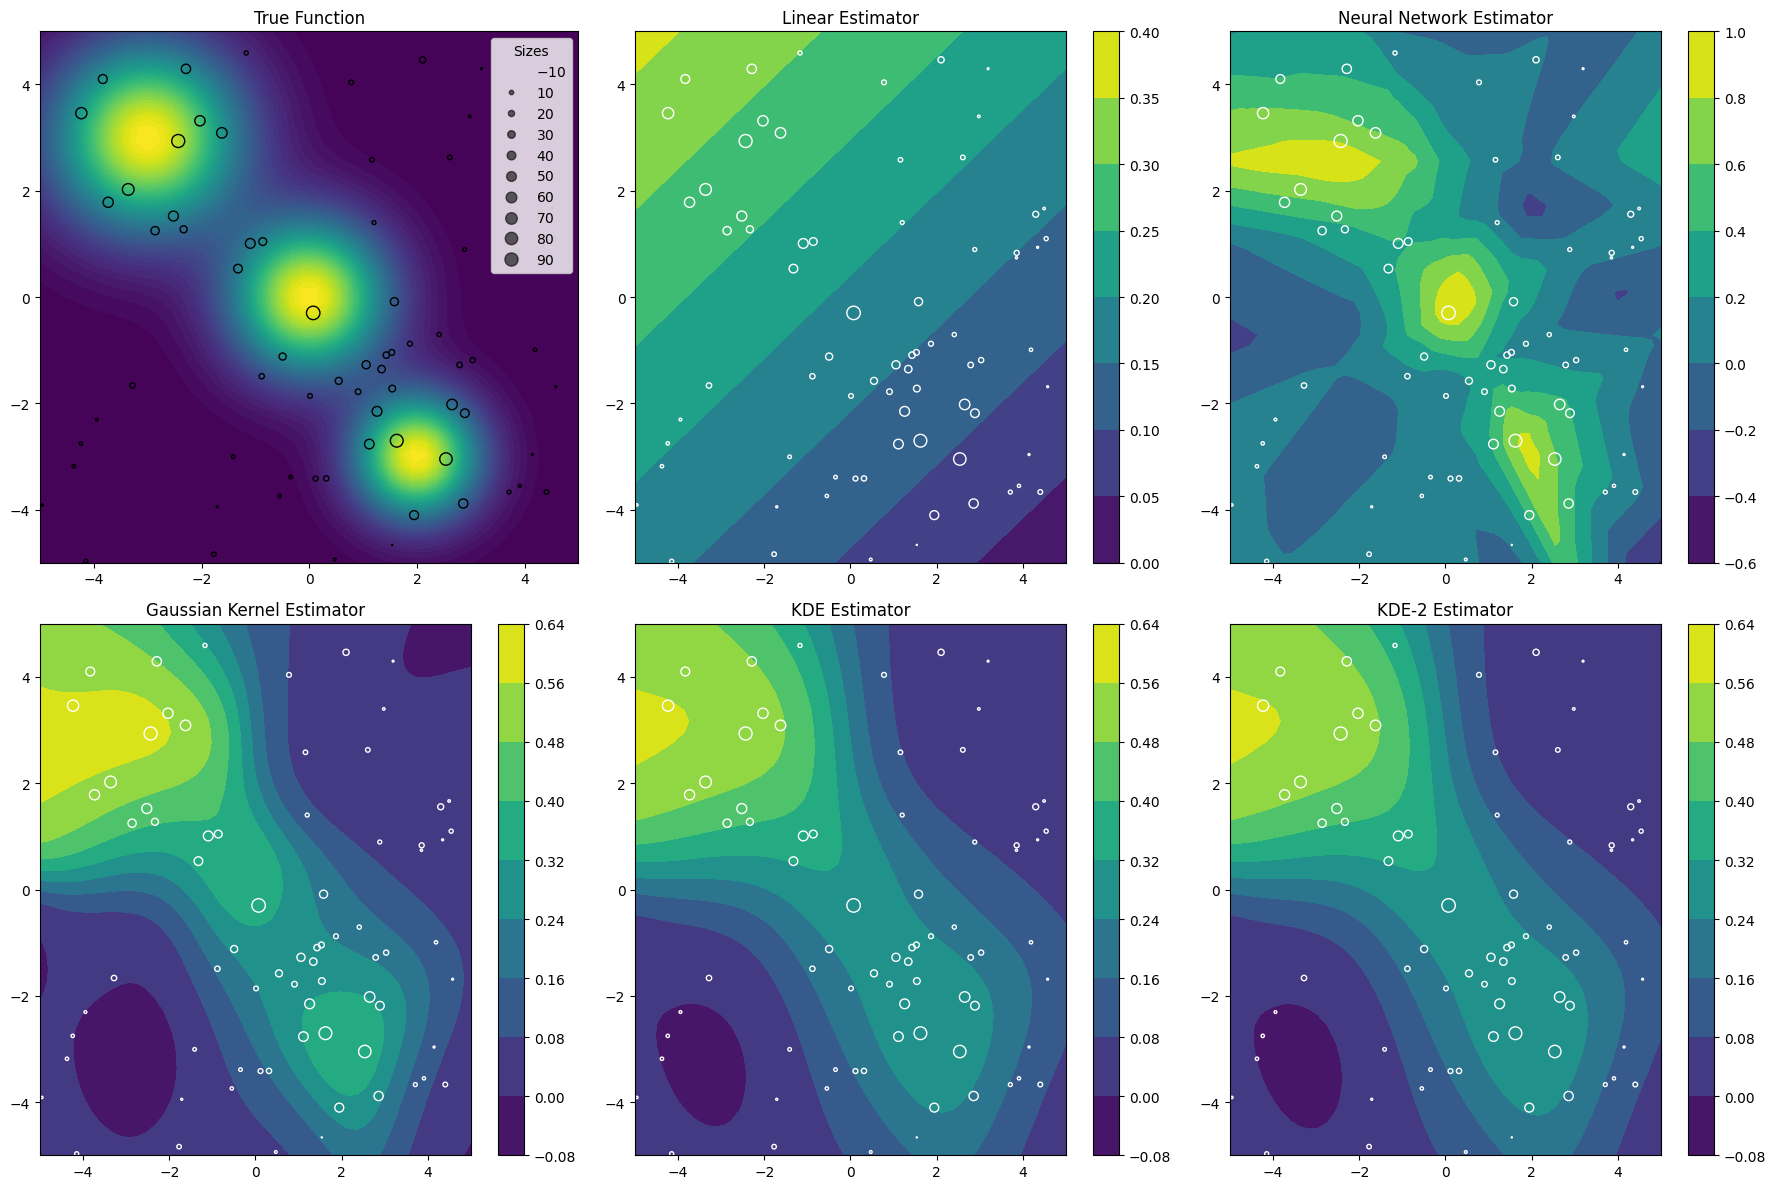

In [ ]:
from matplotlib import ticker

# Initialize estimators
estimators = {
    "Linear": LinearEstimator(input_dim=2),
    "Neural Network": NNEstimator(input_dim=2, hidden_dim=32),
    "Gaussian Kernel": GaussianKernelEstimator(input_dim=2, bandwidth=1.0),
    "KDE": KDEEstimator(input_dim=2),
    "KDE-2" : KDEEstimatorV2(input_dim=2)
}

# Fit each estimator and compute predictions
predictions = {}
for name, estimator in estimators.items():
    estimator.fit(x, y)
    predictions[name] = estimator.predict(grid_points).reshape(50, 50)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# True function
if true_values is not None:
    axes[0].contourf(grid_x, grid_y, true_values, levels=50, cmap='viridis')
    axes[0].scatter(x[:, 0], x[:, 1], s=y*100, edgecolor='k', facecolors='none')
    
axes[0].set_title("True Function")

# Estimated functions
for i, (name, pred) in enumerate(predictions.items(), start=1):
    contour = axes[i].contourf(grid_x, grid_y, pred)
    scatter = axes[i].scatter(x[:, 0], x[:, 1], s=y*100, edgecolor='w', facecolors='none')

    axes[i].set_title(f"{name} Estimator")
    plt.colorbar(contour, ax=axes[i])
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = axes[0].legend(handles, labels, title="Sizes", loc="upper right")
plt.tight_layout()
plt.show()
